##### import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam

In [4]:
# Read the labels.csv file


DATA_DIR = "/final/dog-breed-identification"
labels_all = pd.read_csv(join(DATA_DIR, "labels.csv"))
print(labels_all.shape)
labels_all.head()


(10222, 2)


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

/Users/vishnusuresh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

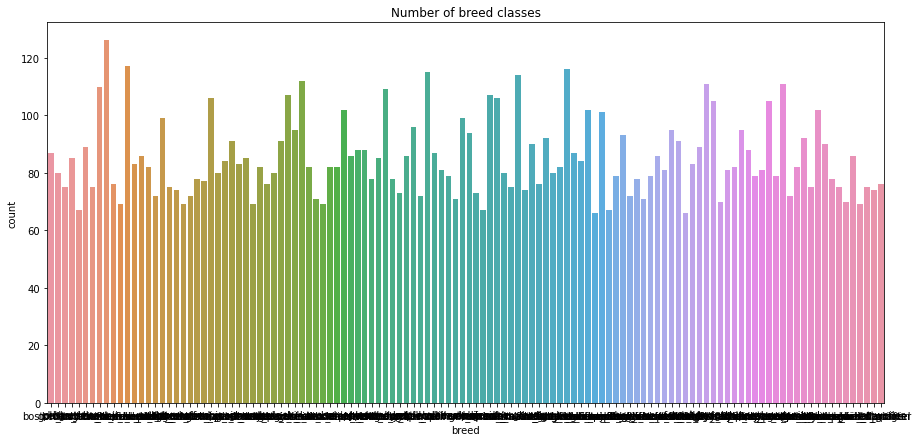

In [5]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
plt.figure(figsize=(15,7))
g = sns.countplot(breeds_all)
plt.title("Number of breed classes")
breed_counts = breeds_all.value_counts()
breed_counts

In [6]:
# Selecting breeds

CLASS_NAMES = ['scottish_deerhound',
               'maltese_dog',
               'bernese_mountain_dog']

labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]

labels = labels.reset_index()
labels.head()

index                                id                 breed
0      9  0042188c895a2f14ef64a918ed9c7b64    scottish_deerhound
1     12  00693b8bc2470375cc744a6391d397ec           maltese_dog
2     79  01e787576c003930f96c966f9c3e1d44    scottish_deerhound
3     90  022b34fd8734b39995a9f38a4f3e7b6b           maltese_dog
4    118  02d54f0dfb40038765e838459ae8c956  bernese_mountain_dog

In [7]:
def read_img(img_id, train_or_test, size):
    
    img = image.load_img(join(DATA_DIR, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [8]:
# Loading the training set

IMG_SIZE = 224

X_all = np.zeros((len(labels), IMG_SIZE, IMG_SIZE, 3), dtype='float32')
Y_all = label_binarize(labels['breed'], classes = CLASS_NAMES)

for i in tqdm(range(len(labels))):
    img = read_img(labels['id'][i], 'train', (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img.copy(), axis=0)
    X_all[i] = x / 255.0
    
print('Train Images shape: {} size: {:,}'.format(X_all.shape, X_all.size))
print('One-hot encoded output shape: {} size: {:,}'.format(Y_all.shape, Y_all.size))

100%|██████████| 357/357 [00:03<00:00, 105.60it/s]

Train Images shape: (357, 224, 224, 3) size: 53,738,496
One-hot encoded output shape: (357, 3) size: 1,071


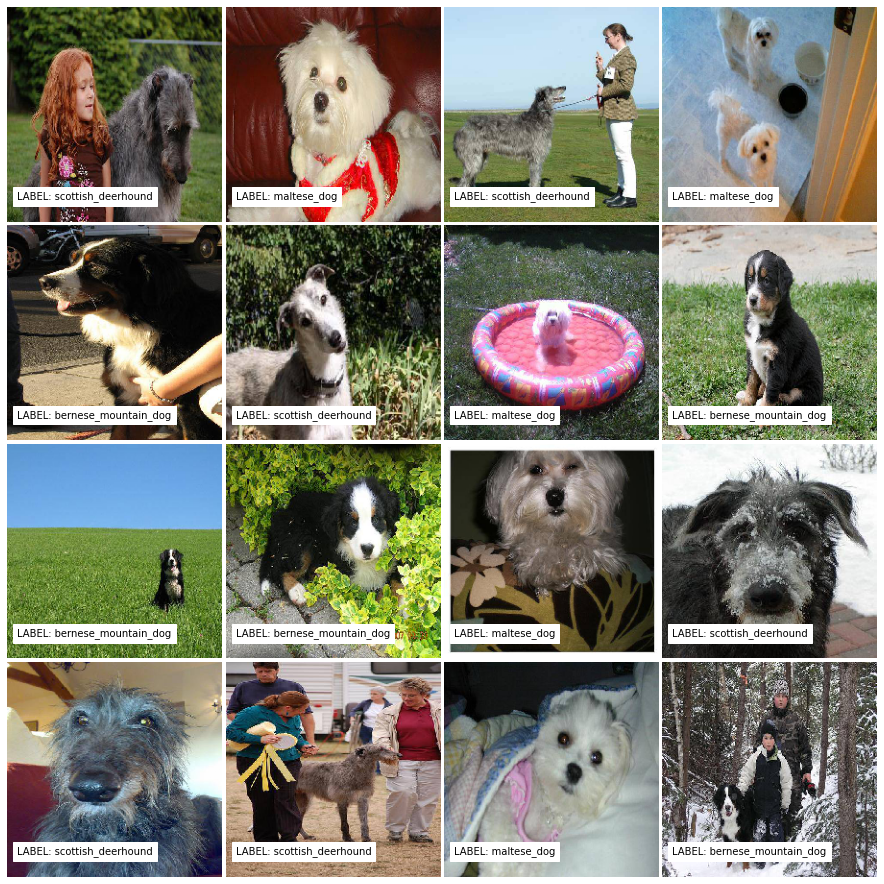

In [9]:
# Show example images
IMG_GRID_ROWS = 4
IMG_GRID_COLUMNS = 4
num_of_images = IMG_GRID_ROWS * IMG_GRID_COLUMNS
fig = plt.figure(1, figsize=(IMG_GRID_COLUMNS * 4, IMG_GRID_ROWS * 4))
grid = ImageGrid(fig, 111, nrows_ncols=(IMG_GRID_ROWS, IMG_GRID_COLUMNS), axes_pad=0.05)

for i in range(num_of_images):
    ax = grid[i]
    ax.imshow(X_all[i,:,:,:])
    class_index = np.argmax(Y_all[i])
    ax.text(10, 200, ('LABEL: %s' % CLASS_NAMES[class_index]), backgroundcolor='w')
    ax.axis('off')
plt.show()

In [10]:
# Building the Model

model = Sequential()

# 1. Convolution Layer + MaxPool
model.add(Conv2D(filters = 8, kernel_size = (5,5),
                 activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 2. Convolution Layer + MaxPool
model.add(Conv2D(filters = 16, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 3. Convolution Layer + MaxPool
model.add(Conv2D(filters = 32, kernel_size = (7,7),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# 4. Convolution Layer + MaxPool
model.add(Conv2D(filters = 64, kernel_size = (5,5),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# fully connected
model.add(Flatten())
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(len(CLASS_NAMES), activation = "softmax"))

learning_rate = 0.0005

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 8)       608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 8)       0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        2

In [11]:
# Splitting the training data set into training and validation data sets

X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_all, Y_all, test_size = 0.1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [12]:
#Save the model during training 

save_at = "/Users/aishw/final/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

In [1]:
# Data augmentation

datagen = ImageDataGenerator(
        rotation_range = 20,  # randomly rotate images
        zoom_range = 0.2, # Randomly zoom images
        width_shift_range = 0.25,  # randomly shift images horizontally
        height_shift_range = 0.25,  # randomly shift images vertically
        horizontal_flip = True,  # randomly flip images horizontally
        vertical_flip = False)  # randomly flip images vertically

datagen.fit(X_train)

NameError: name 'ImageDataGenerator' is not defined

In [14]:
# Training the model

epochs = 300
batch_size = 20

# Normal training

#history = model.fit(X_train, Y_train,
#                    batch_size = batch_size,
#                    epochs = epochs,
#                    validation_data = (X_val, Y_val),
#                    callbacks = [save_best],)

# Training with data augmentation

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_val, Y_val),
                              callbacks = [save_best],
                              steps_per_epoch=X_train.shape[0] // batch_size)

/Users/vishnusuresh/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
12/12 [==============================] - 18s 1s/step - loss: 1.2344 - accuracy: 0.3230 - val_loss: 1.0981 - val_accuracy: 0.3385
Epoch 2/300
12/12 [==============================] - 12s 966ms/step - loss: 1.0971 - accuracy: 0.3625 - val_loss: 1.0982 - val_accuracy: 0.3385
Epoch 3/300
12/12 [==============================] - 13s 1s/step - loss: 1.1025 - accuracy: 0.3311 - val_loss: 1.0990 - val_accuracy: 0.3077
Epoch 4/300
12/12 [==============================] - 14s 1s/step - loss: 1.0983 - accuracy: 0.3597 - val_loss: 1.0970 - val_accuracy: 0.4462
Epoch 5/300
12/12 [==============================] - 14s 1s/step - loss: 1.0938 - accuracy: 0.3253 - val_loss: 1.0999 - val_accuracy: 0.3231
Epoch 6/300
12/12 [==============================] - 12s 958ms/step - loss: 1.0907 - accuracy: 0.4456 - val_loss: 1.0966 - val_accuracy: 0.4154
Epoch 7/300
12/12 [==============================] - 13s 1s/step - loss: 1.0533 - accuracy: 0.4587 - val_loss: 1.1424 - val_accuracy: 0.3538
Epoch 8

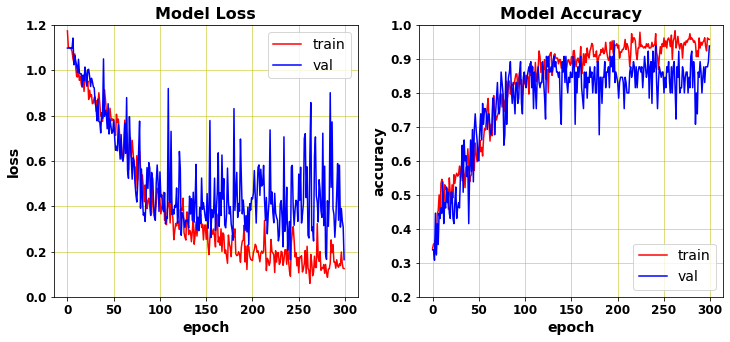

In [15]:
# Plot the training history

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss', weight='bold', fontsize=16)
plt.ylabel('loss', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.0, 1.2)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper right', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')

plt.subplot(122)
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.2, 1.0)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='lower right', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')

plt.show()

In [17]:
# Making predictions on the test dataset

#model = load_model('/kaggle/working/model.hdf5')
model = load_model('/Users/vishnusuresh/final/model.hdf5')
Y_pred = model.predict(X_test)
score = model.evaluate(X_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Accuracy over the test set: 
  0.0 %


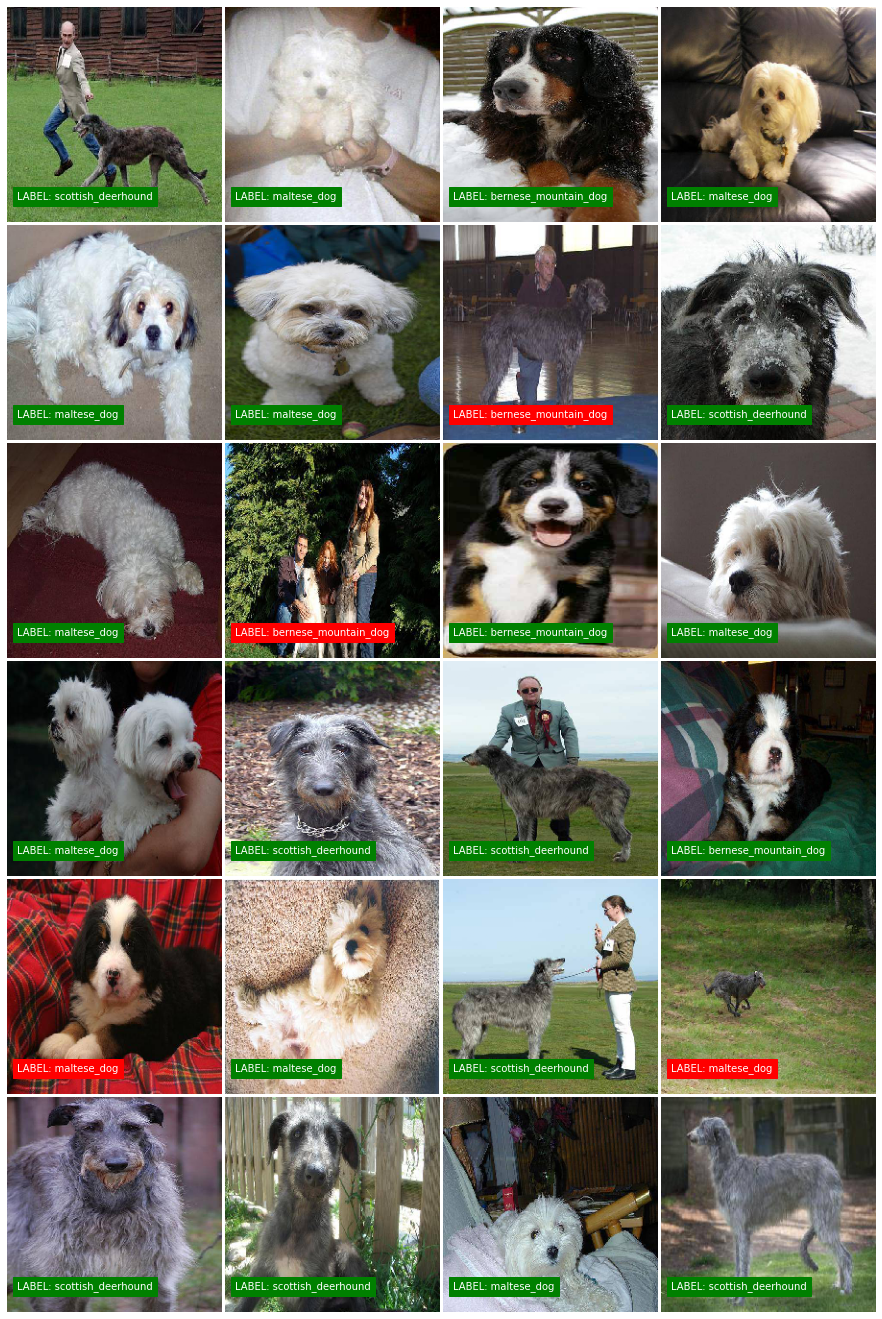

In [18]:
# Show example predictions

IMG_GRID_ROWS = 6
IMG_GRID_COLUMNS = 4
num_of_images = IMG_GRID_ROWS * IMG_GRID_COLUMNS
fig = plt.figure(1, figsize=(IMG_GRID_COLUMNS * 4, IMG_GRID_ROWS * 4))
grid = ImageGrid(fig, 111, nrows_ncols=(IMG_GRID_ROWS, IMG_GRID_COLUMNS), axes_pad=0.05)

for i in range(num_of_images):
    ax = grid[i]
    ax.imshow(X_test[i,:,:,:])
    
    class_index_pred = np.argmax(Y_pred[i])
    class_index_val = np.argmax(Y_test[i])
    
    if class_index_val == class_index_pred:
        background_color = 'g'
    else:
        background_color = 'r'
        
    ax.text(10, 200, ('LABEL: %s' % (CLASS_NAMES[class_index_pred])),
            color = 'w',
            backgroundcolor = background_color)
    
    ax.axis('off')
plt.show()

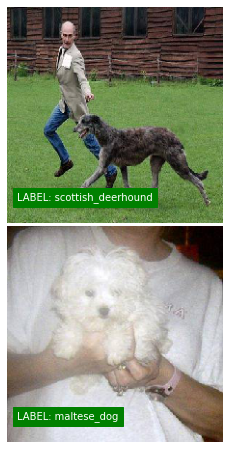

In [33]:
# Show example predictions
IMG_GRID_ROWS = 2
IMG_GRID_COLUMNS = 1
num_of_images = IMG_GRID_ROWS * IMG_GRID_COLUMNS
fig = plt.figure(1, figsize=(IMG_GRID_COLUMNS * 4, IMG_GRID_ROWS * 4))
grid = ImageGrid(fig, 111, nrows_ncols=(IMG_GRID_ROWS, IMG_GRID_COLUMNS), axes_pad=0.05)

for i in range(num_of_images):
    ax = grid[i]
    ax.imshow(X_test[i,:,:,:])
    
    class_index_pred = np.argmax(Y_pred[i])
    class_index_val = np.argmax(Y_test[i])
    
    if class_index_val == class_index_pred:
        background_color = 'g'
    else:
        background_color = 'r'
        
    ax.text(10, 200, ('LABEL: %s' % (CLASS_NAMES[class_index_pred])),
            color = 'w',
            backgroundcolor = background_color)
    
    ax.axis('off')

plt.show()

In [24]:
X_test

array([[[[0.18039216, 0.16862746, 0.13333334],
         [0.15294118, 0.14117648, 0.10588235],
         [0.14901961, 0.13725491, 0.10980392],
         ...,
         [0.10588235, 0.07058824, 0.03529412],
         [0.17254902, 0.13333334, 0.09803922],
         [0.17254902, 0.13333334, 0.09803922]],

        [[0.05882353, 0.04705882, 0.01176471],
         [0.09803922, 0.08627451, 0.05098039],
         [0.16862746, 0.15686275, 0.12941177],
         ...,
         [0.2901961 , 0.20784314, 0.1882353 ],
         [0.28235295, 0.2       , 0.18039216],
         [0.24705882, 0.16470589, 0.14509805]],

        [[0.1764706 , 0.16078432, 0.1254902 ],
         [0.16078432, 0.14901961, 0.11372549],
         [0.21176471, 0.2       , 0.17254902],
         ...,
         [0.30588236, 0.19607843, 0.18431373],
         [0.3019608 , 0.18431373, 0.1764706 ],
         [0.27058825, 0.15294118, 0.14509805]],

        ...,

        [[0.3647059 , 0.5058824 , 0.22352941],
         [0.40784314, 0.5372549 , 0.25882354]

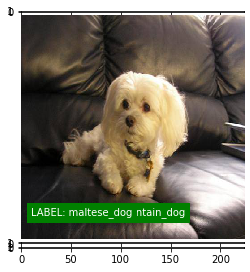

In [41]:
# Show example predictions

IMG_GRID_ROWS = 4
IMG_GRID_COLUMNS = 1
num_of_images = IMG_GRID_ROWS * IMG_GRID_COLUMNS
fig = plt.figure(1, figsize=(IMG_GRID_COLUMNS * 4, IMG_GRID_ROWS * 4))
grid = ImageGrid(fig, 111, nrows_ncols=(IMG_GRID_ROWS, IMG_GRID_COLUMNS), axes_pad=0.05)

for i in range(num_of_images):
    ax = grid[1]
    ax.imshow(X_test[i,:,:,:])
    
    class_index_pred = np.argmax(Y_pred[i])
    class_index_val = np.argmax(Y_test[i])
    
    if class_index_val == class_index_pred:
        background_color = 'g'
    else:
        background_color = 'r'
        
    ax.text(10, 200, ('LABEL: %s' % (CLASS_NAMES[class_index_pred])),
            color = 'w',
            backgroundcolor = background_color)
    
    ax.axis('off')

plt.show()